# Tutorial : Quick Start with Dynap-SE2

## Introduction

<img src=https://raw.githubusercontent.com/synsense/rockpool/dev/dynapse_support/docs/devices/DynapSE/images/dynapse2.jpeg
 width="1024">

Dynap-SE2, (DYnamic Neuromorphic Asynchronous Processor - ScalablE 2) inherits the event-driven nature of the DYNAP family. The mixed-signal chip uses analog spiking neurons and analog synapses as the computing units, which directly emulates biological behavior. Transistors of the neural cores operate in the subthreshold region, which results in power consumption of about one-thousandth to one-millionth of the state-of-the-art digital neuromorphic chips, below mW. Each chip features 1024 adaptive exponential integrate-and-fire analog ultra-low-power spiking neurons and 64 synapses per neuron with configurable delay, weight, and short-term plasticity. 


## Architecture Overview

<img src=https://raw.githubusercontent.com/synsense/rockpool/dev/dynapse_support/docs/devices/DynapSE/images/dynapse_architecture.png width="1024">

Each Dynap-SE2 chip has 1024 neurons distributed over 4 individually configurable neural cores, connected by a patented hierarchical routing grid. 
The tag-based routing infrastructure provides direct communication from one chip to 15×15 surrounding chips (7 steps west, 7 steps north, 7 steps east, 7 steps south), connecting up to 230k neurons. 
Each neural core holds a `parameter group` to set the neuronal and synaptic parameters for its 256 neurons and their pre-synaptic synapses. 
The neurons in the same core share the same parameter values, including time constants, refractory periods, synaptic connection strengths and etc. 
Special digital to analog conveters, bias generators denominated as `BG`, set these parameter current values.

The neural computation unit is the main building block creating the dynamics.
Each neural core pieces together 256 analog neurons sharing the same parameter set.
CAM and SRAM are the digital memory blocks holding the transmitting and receiving event configurations.
Analog computation takes place in the synapses and the neuron soma.

Four different synapses: AMPA, GABA, NMDA, and SHUNT, integrate the incoming events and inject current into the membrane.
While AMPA and NMDA produce excitatory post-synaptic potentiation, GABA and SHUNT synapses produce inhibitory post-synaptic potentiation.
In other words, AMPA and NMDA activation increase the chance that the neuron fires; GABA and SHUNT activation decrease the firing probability.
The listening event setting stored in the CAM refers to a synapse type.
Therefore, each of the 64 connections of a neuron can specify its synaptic processing unit.

Neuron soma integrates the injection currents and holds a temporal state.
Charging and discharging capacitors in configurable paths designates the temporal behavior.
A secondary reading on the membrane capacitance, the membrane current, functions as the temporal state variable.
Upon membrane current reaching the firing threshold, the neuron's reset mechanism steps in and triggers the event sensing units.
The event is packaged in AER format and is broadcasted to indicated locations.
In this way, the neuron computes the dynamics using analog sub-threshold circuits but conveys the resulting outputs using a digital routing mechanism.

## Simulation

<img src=https://raw.githubusercontent.com/synsense/rockpool/dev/dynapse_support/docs/devices/DynapSE/images/spiking_neuron_operation.png width="1024">

Dynap-SE simulator uses transfer functions of the analog VLSI neuron&synapse implementations and solves them in time.
It uses the Forward-Euler method, which is one of the oldest and simplest algorithms to solve first-order ordinary differential equations given an initial value.
This way, given the current time step state, it predicts the next time step state.
In this method, the following approximation to the first derivative term is applied.

$$
    \dfrac{dy(t)}{dt} = \dfrac{y_{n+1} - y_{n}}{\Delta t}
$$

The trade-off here is to choose the time step wisely, in order not to accumulate the error such that it's misguiding a user.
One should note that here the time-step should be chosen in such a way that any time constant is greater than 10 $\Delta t$.


## Imports

In [1]:
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent, TSContinuous

# Utils
from typing import Optional, Tuple, Any
from rockpool.nn.modules.module import ModuleBase
import numpy as np
from tqdm import tqdm
import time

# - Plotting and config
import matplotlib.pyplot as plt


# - Jax imports
import jax
from jax.experimental.optimizers import adam
from rockpool.training import jax_loss as jl


from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
)

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
 [py.warnings]


## Step 0 : Define the Task

In this one, we will use overly simplified task, in order to be able to grasp the main idea.

In [2]:
T = 4000
f_in = 0.04
dt = 1e-3
Nin = 10
Nout = 2
plt.rcParams["figure.figsize"] = [5.6, 2.8]

In [3]:
def test_network(spec, sample):
    
    ## Connect to device
    se2_devices = find_dynapse_boards()

    found_se2 = len(se2_devices) > 0

    if not found_se2:
        raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
    else:
        se2 = DynapseSamna((10,2),se2_devices[0], spec["config"])
    time.sleep(1)

    se2.reset_state()
    out, state, rec = se2(sample, spec['input_channel_map'])

    fig, axes = plt.subplots(2, 1)

    ticks = list(state["channel_map"].keys())
    labels = [dest.tag for dest in state["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=state["start_time"], t_stop=state["stop_time"]+dt, dt=dt
    ).plot()
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=state["start_time"], t_stop=state["stop_time"]+dt, dt=dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

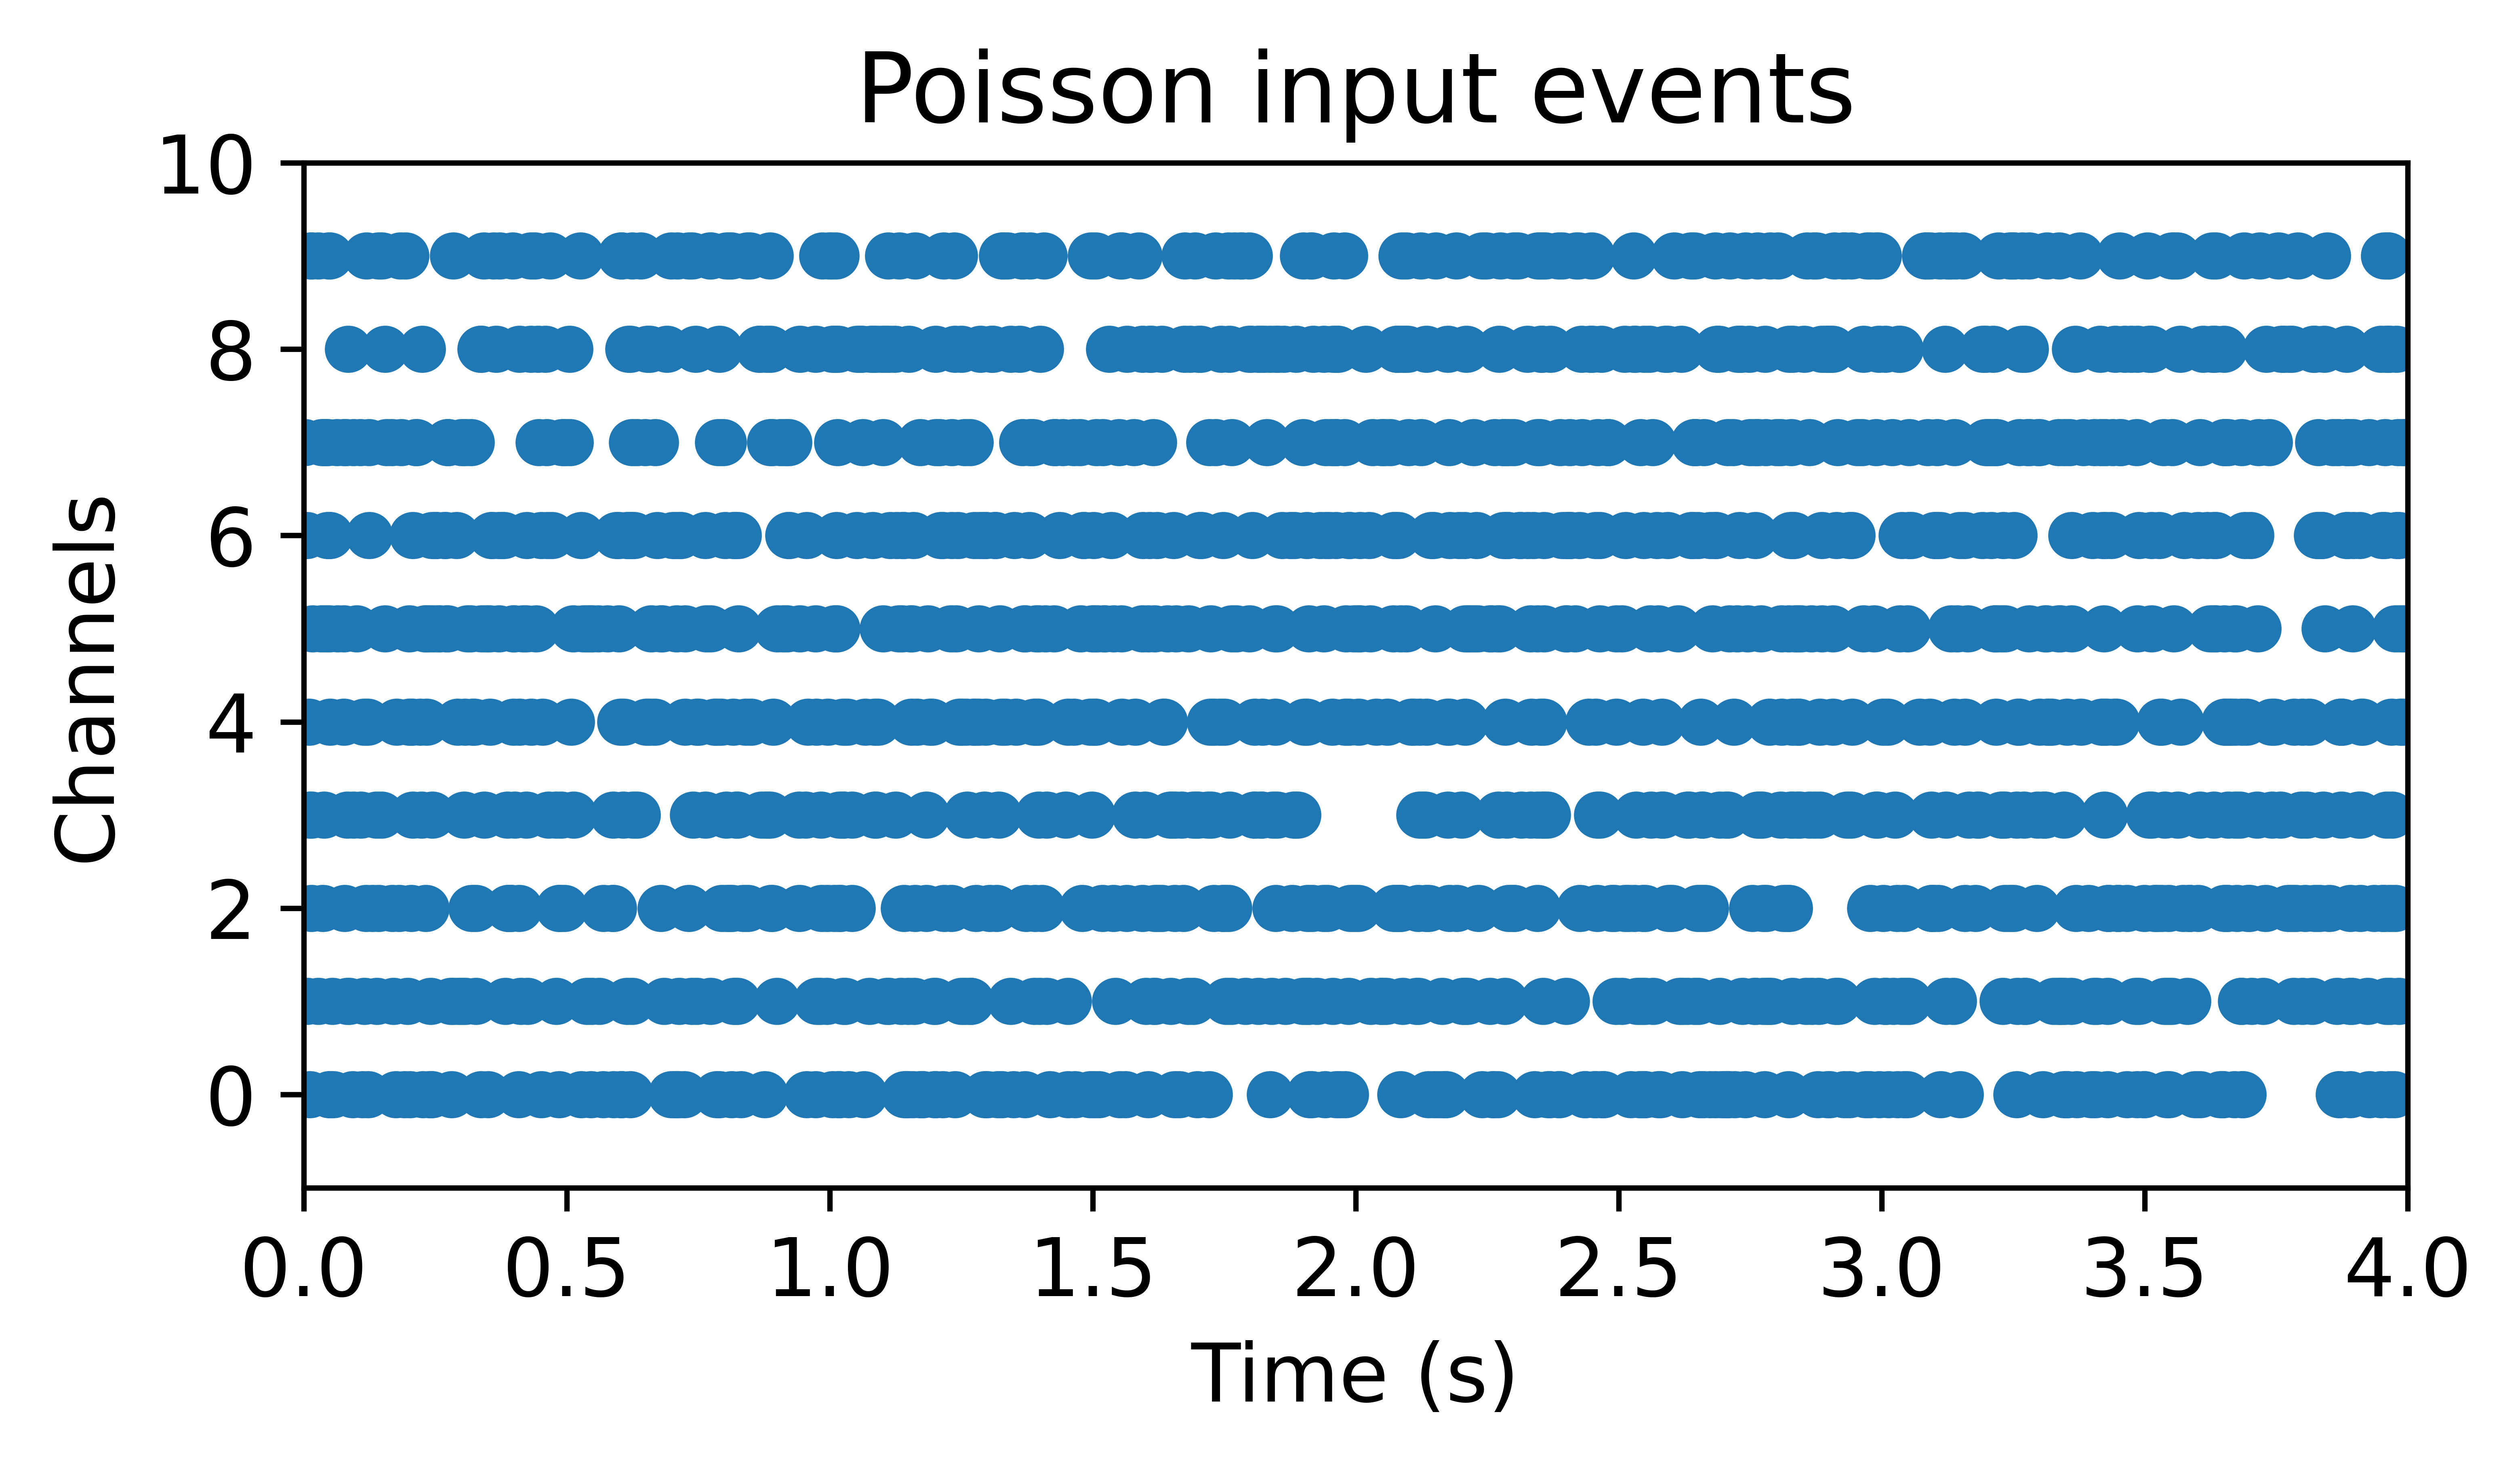

In [4]:
np.random.seed(1995)
input_spikes = np.random.rand(1, T, Nin) < f_in
TSEvent.from_raster(input_spikes[0], dt, name = 'Poisson input events').plot();

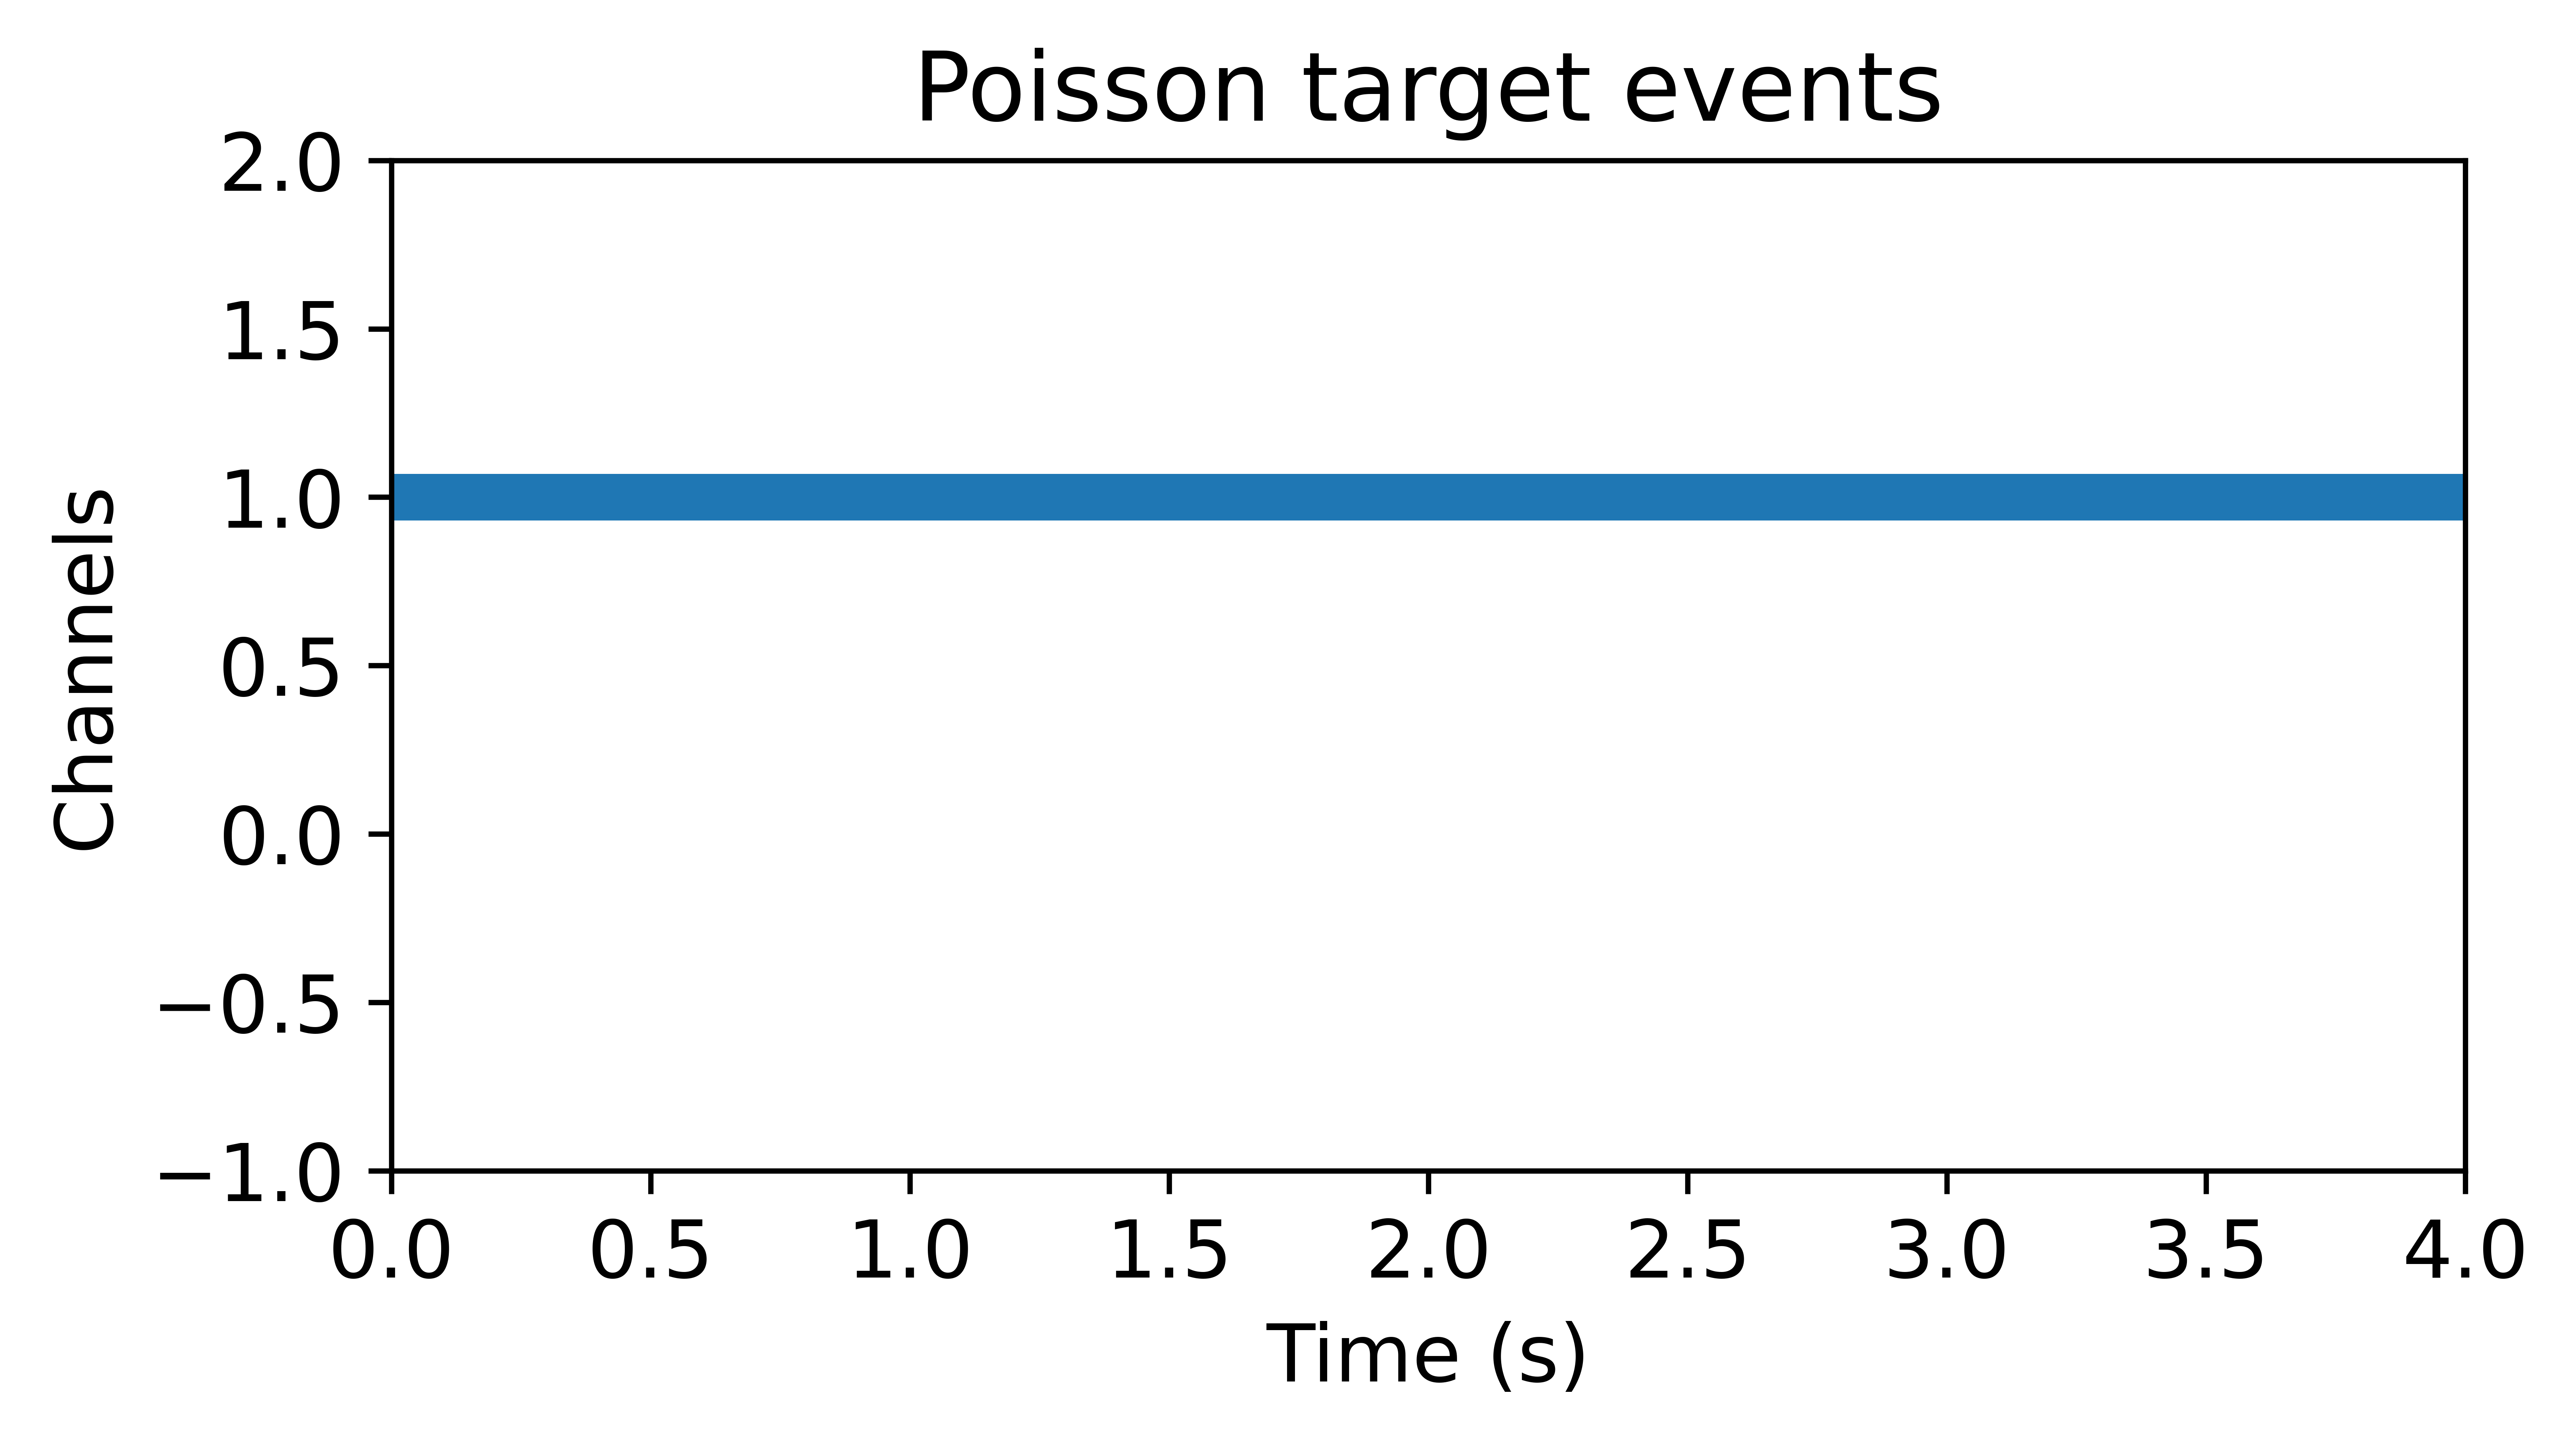

In [5]:
target_spikes = np.full((1, T, Nout), [0,1])
TSEvent.from_raster(target_spikes[0], dt, name = 'Poisson target events').plot();

## Step 1 : Build a Network


In [6]:
net = Sequential(LinearJax((Nin,Nout), has_bias=False), DynapSim(Nout, has_rec=True, Iscale=1e-7))

## Step 2 : Simulate


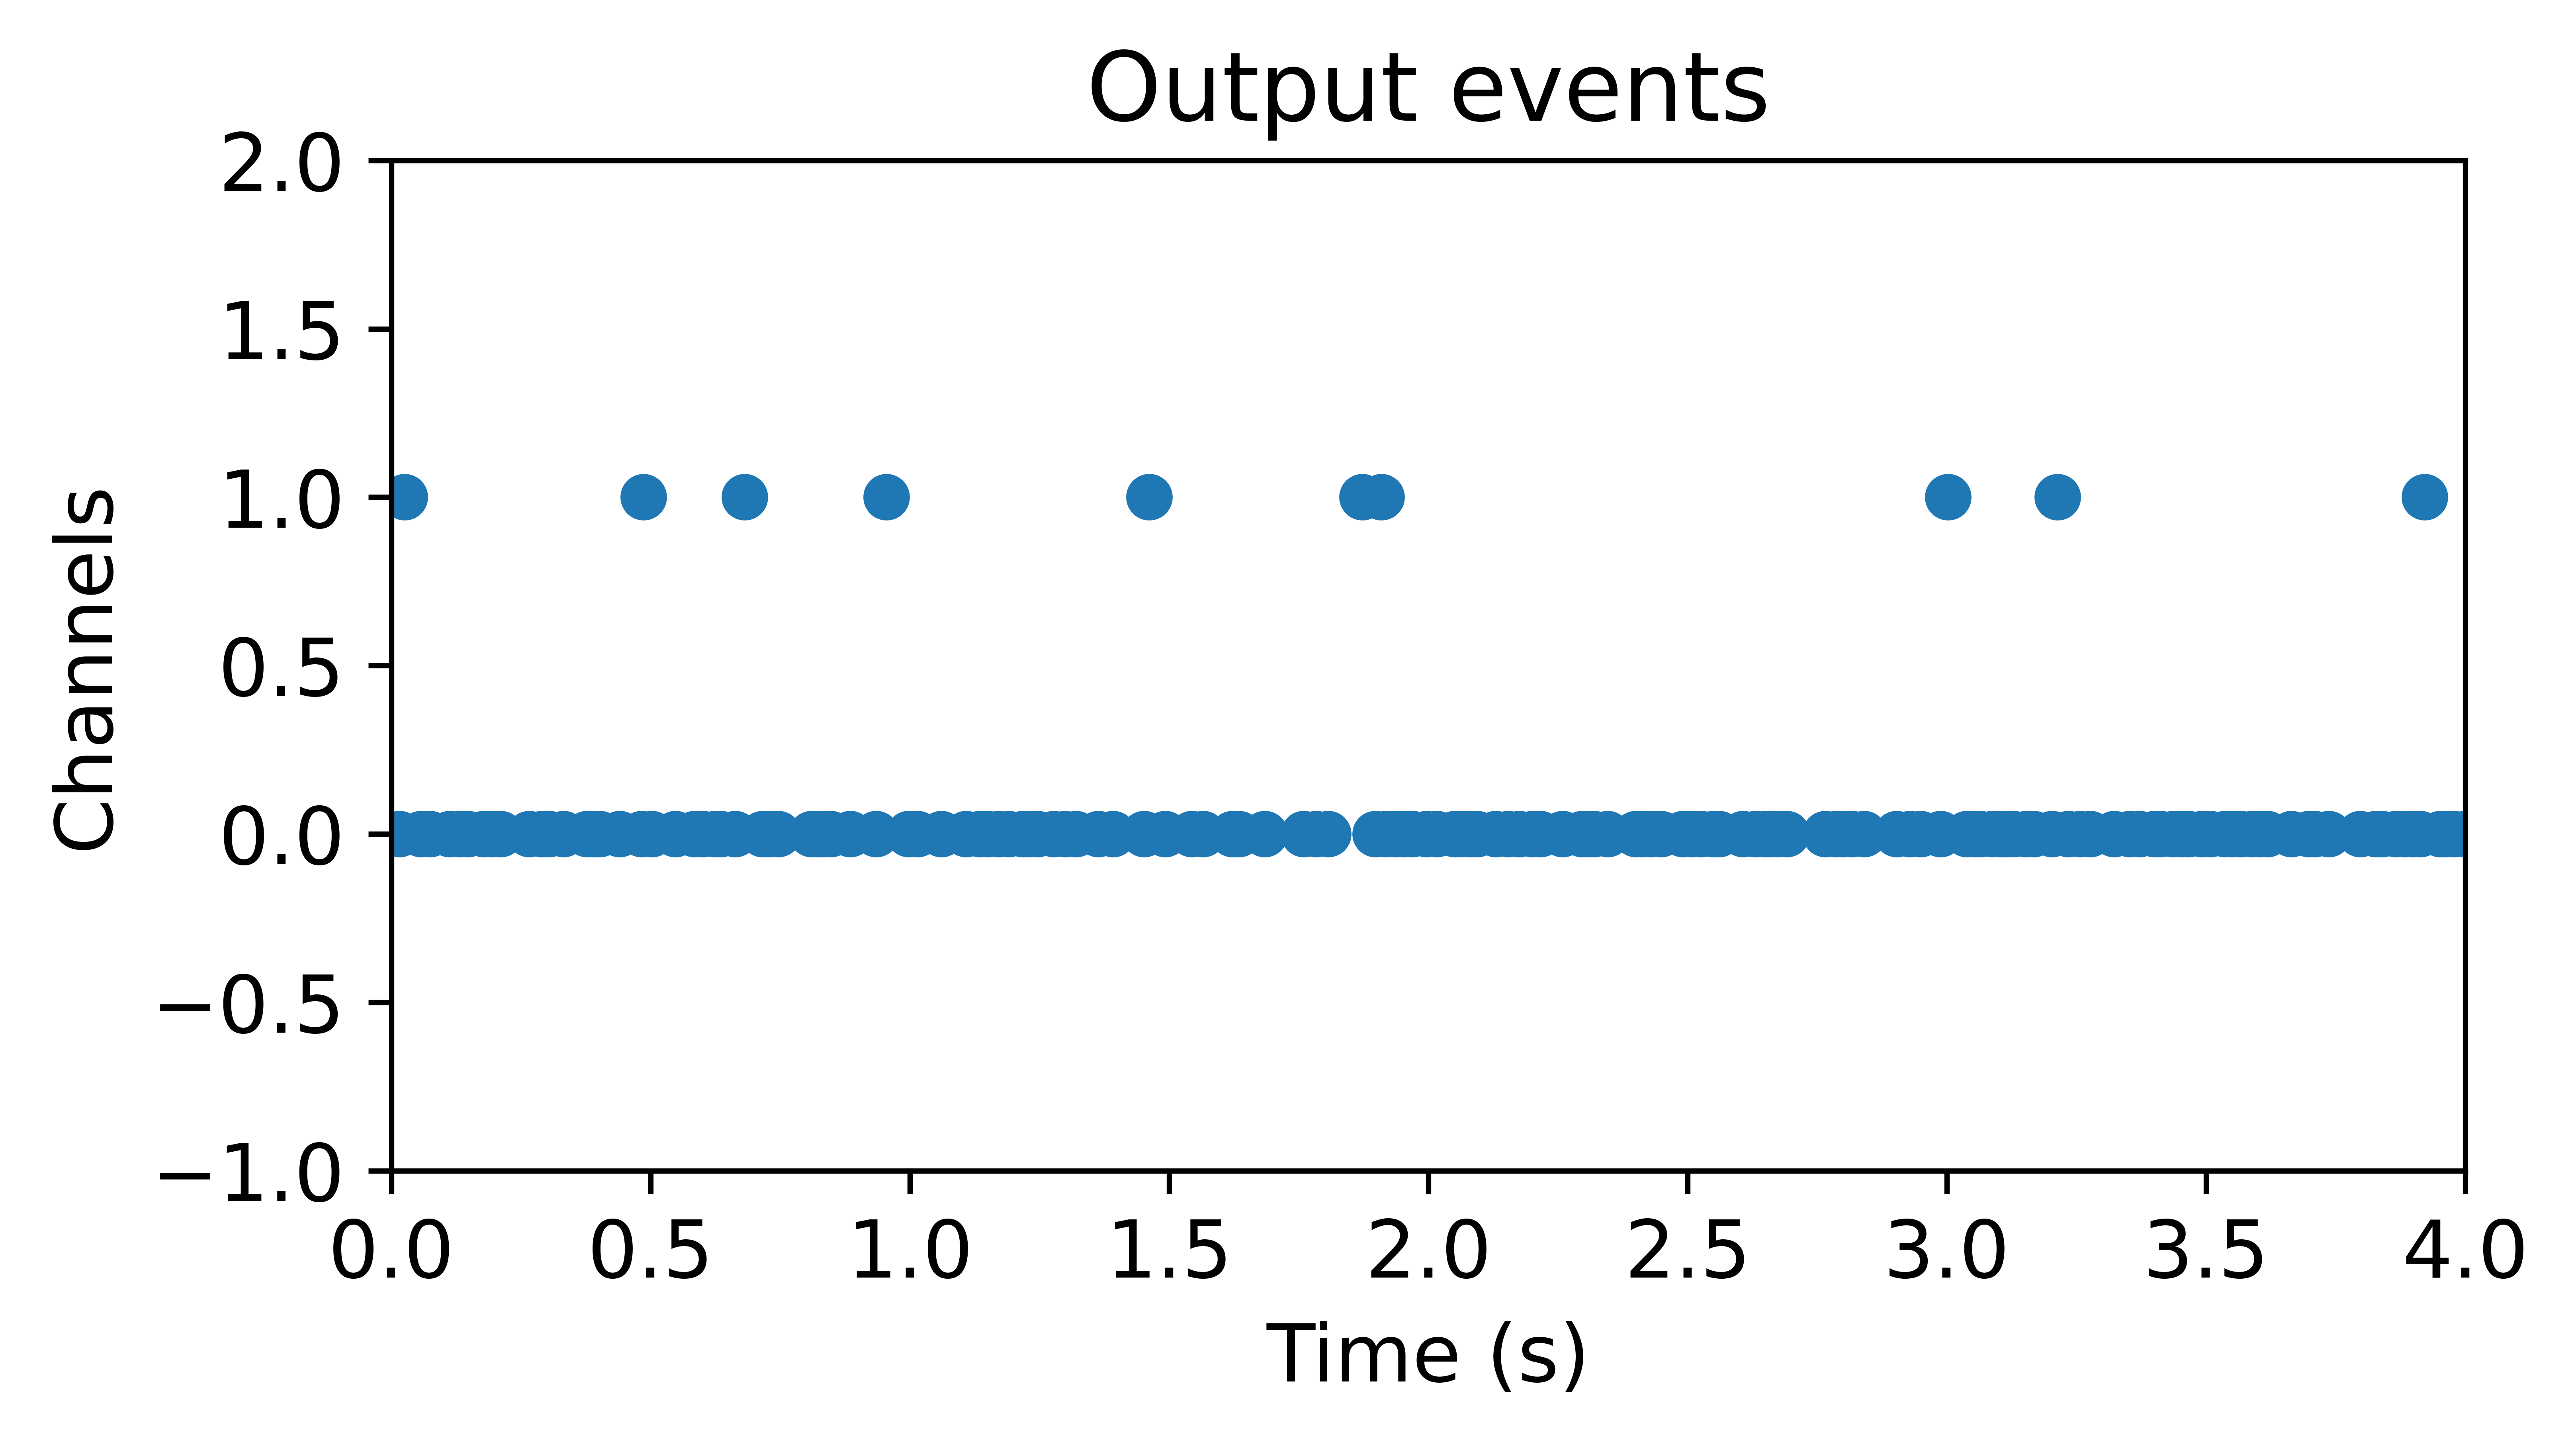

In [7]:
net.reset_state()
out, state, rec = net(input_spikes)
TSEvent.from_raster(out[0], dt, name = 'Output events').plot();

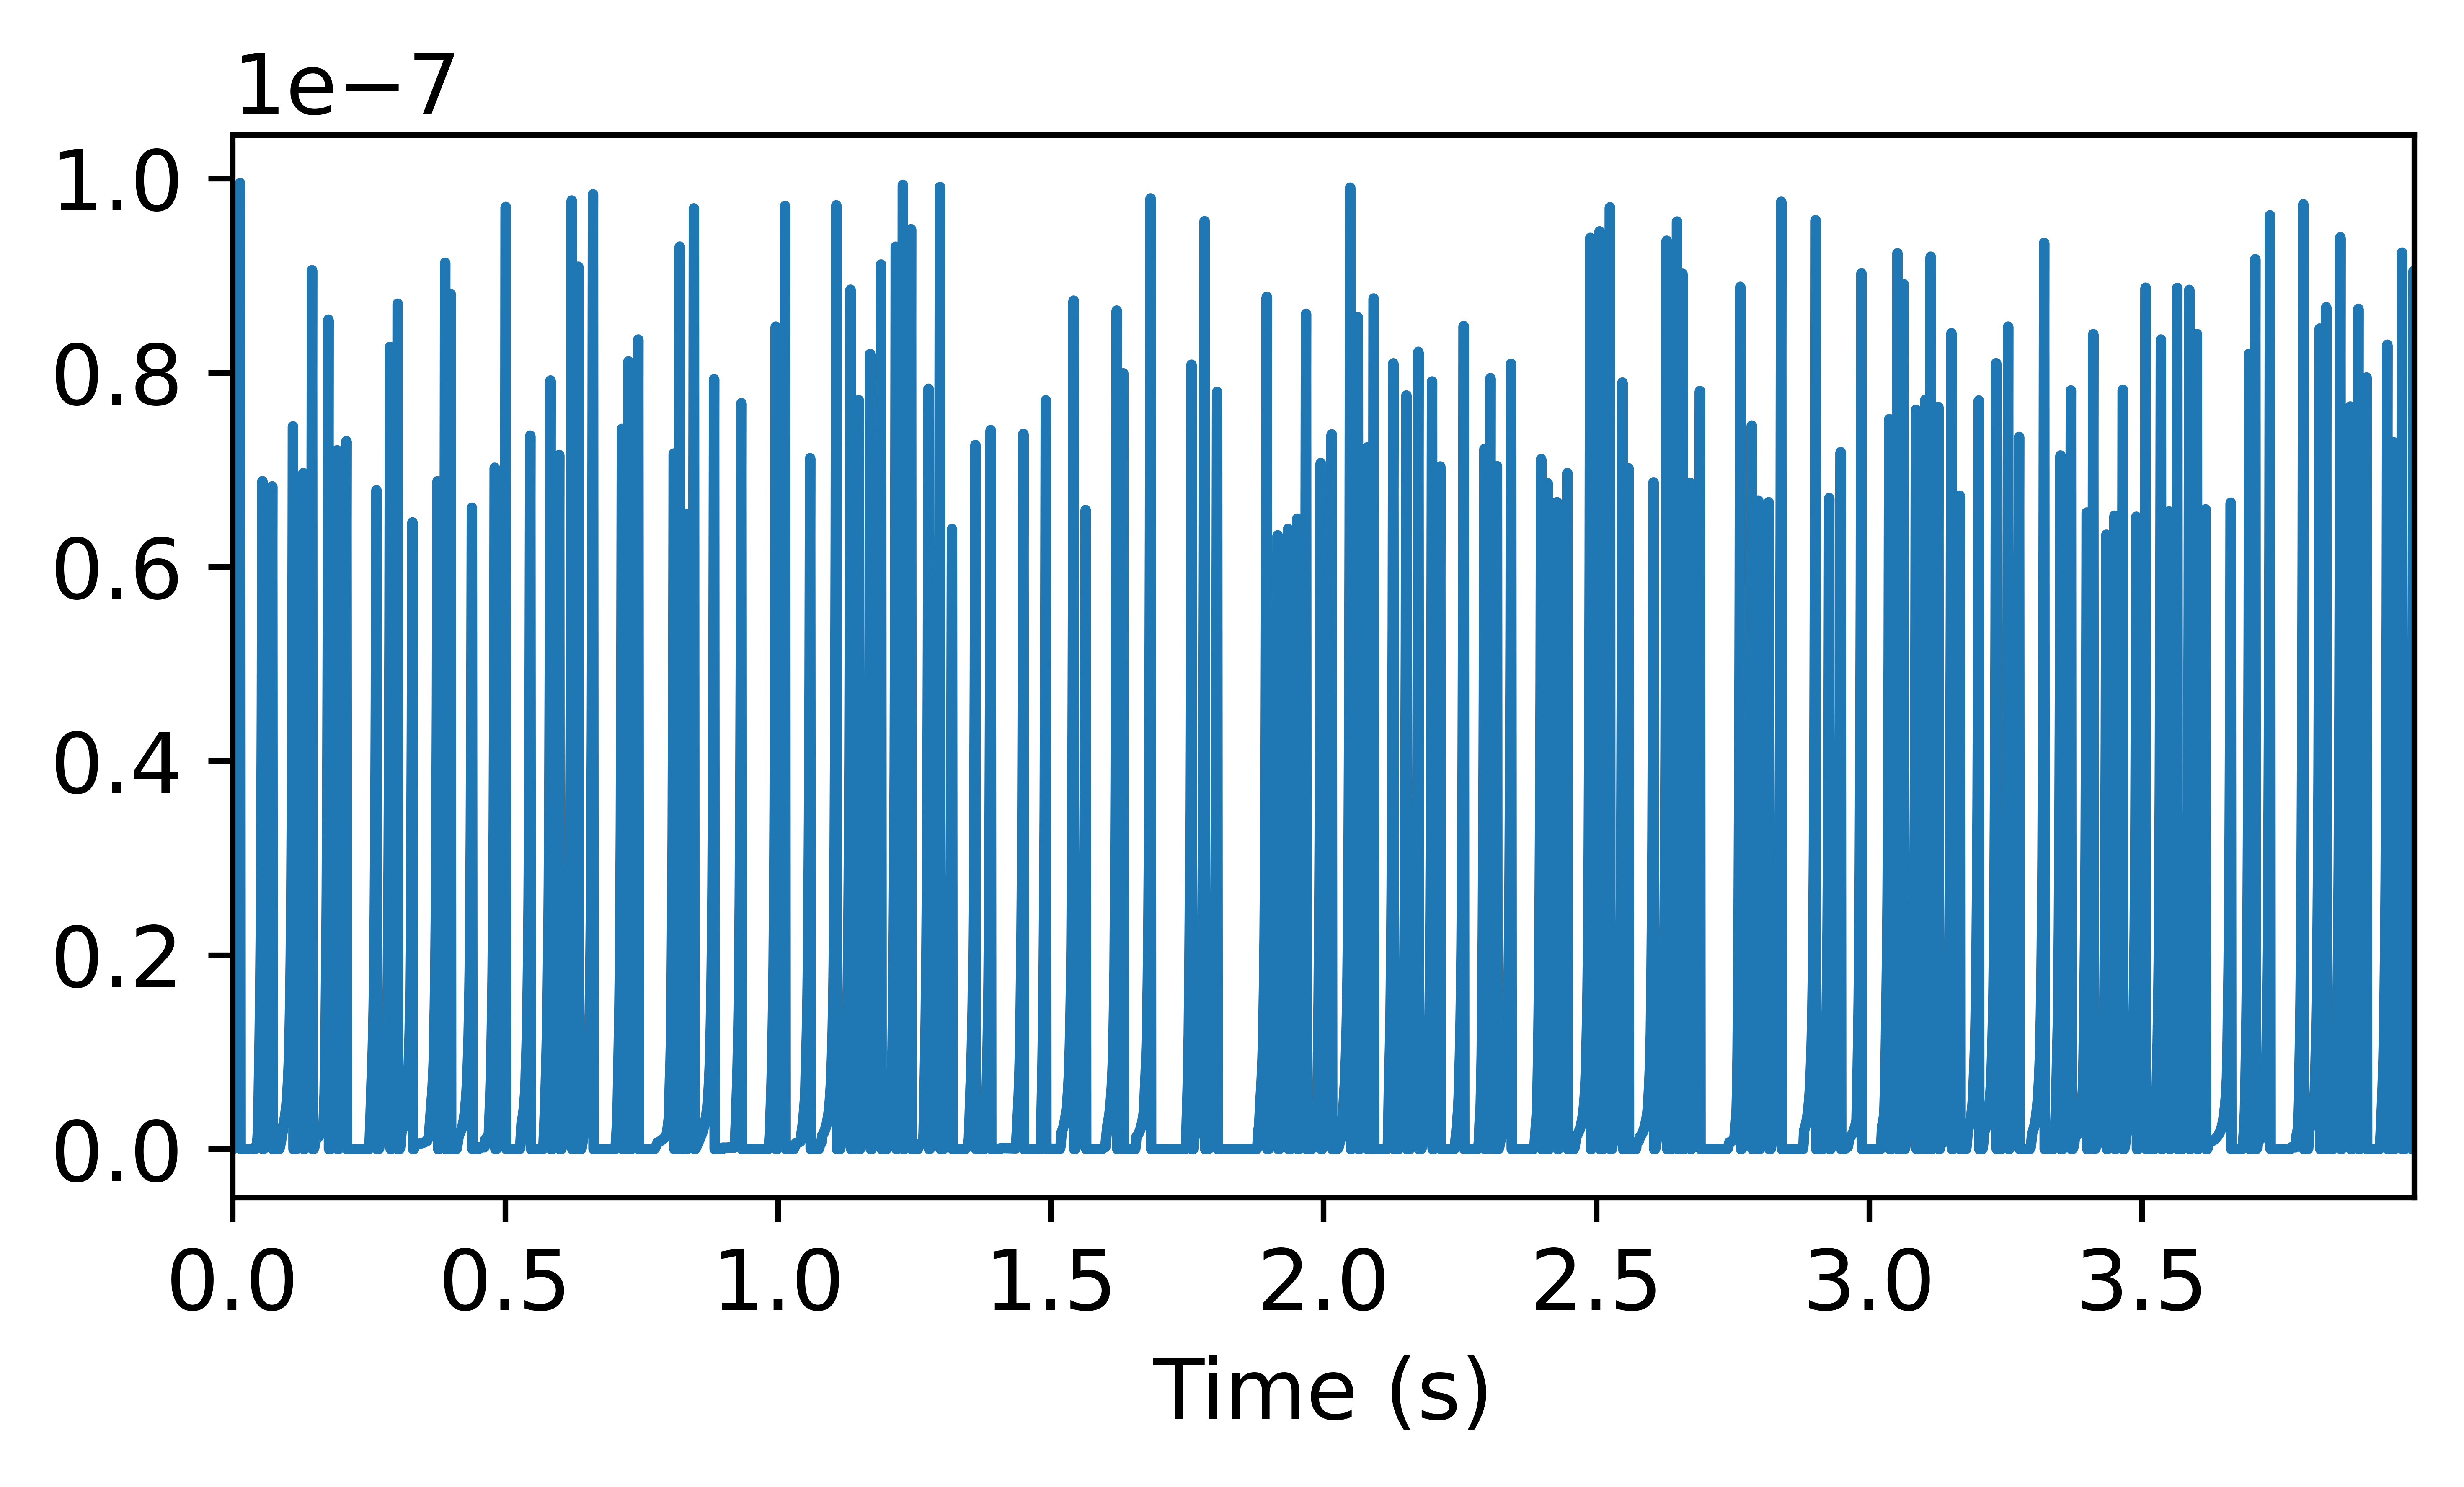

In [8]:
TSContinuous.from_clocked(rec['1_DynapSim']['imem'][0,:,0], dt=dt).plot()

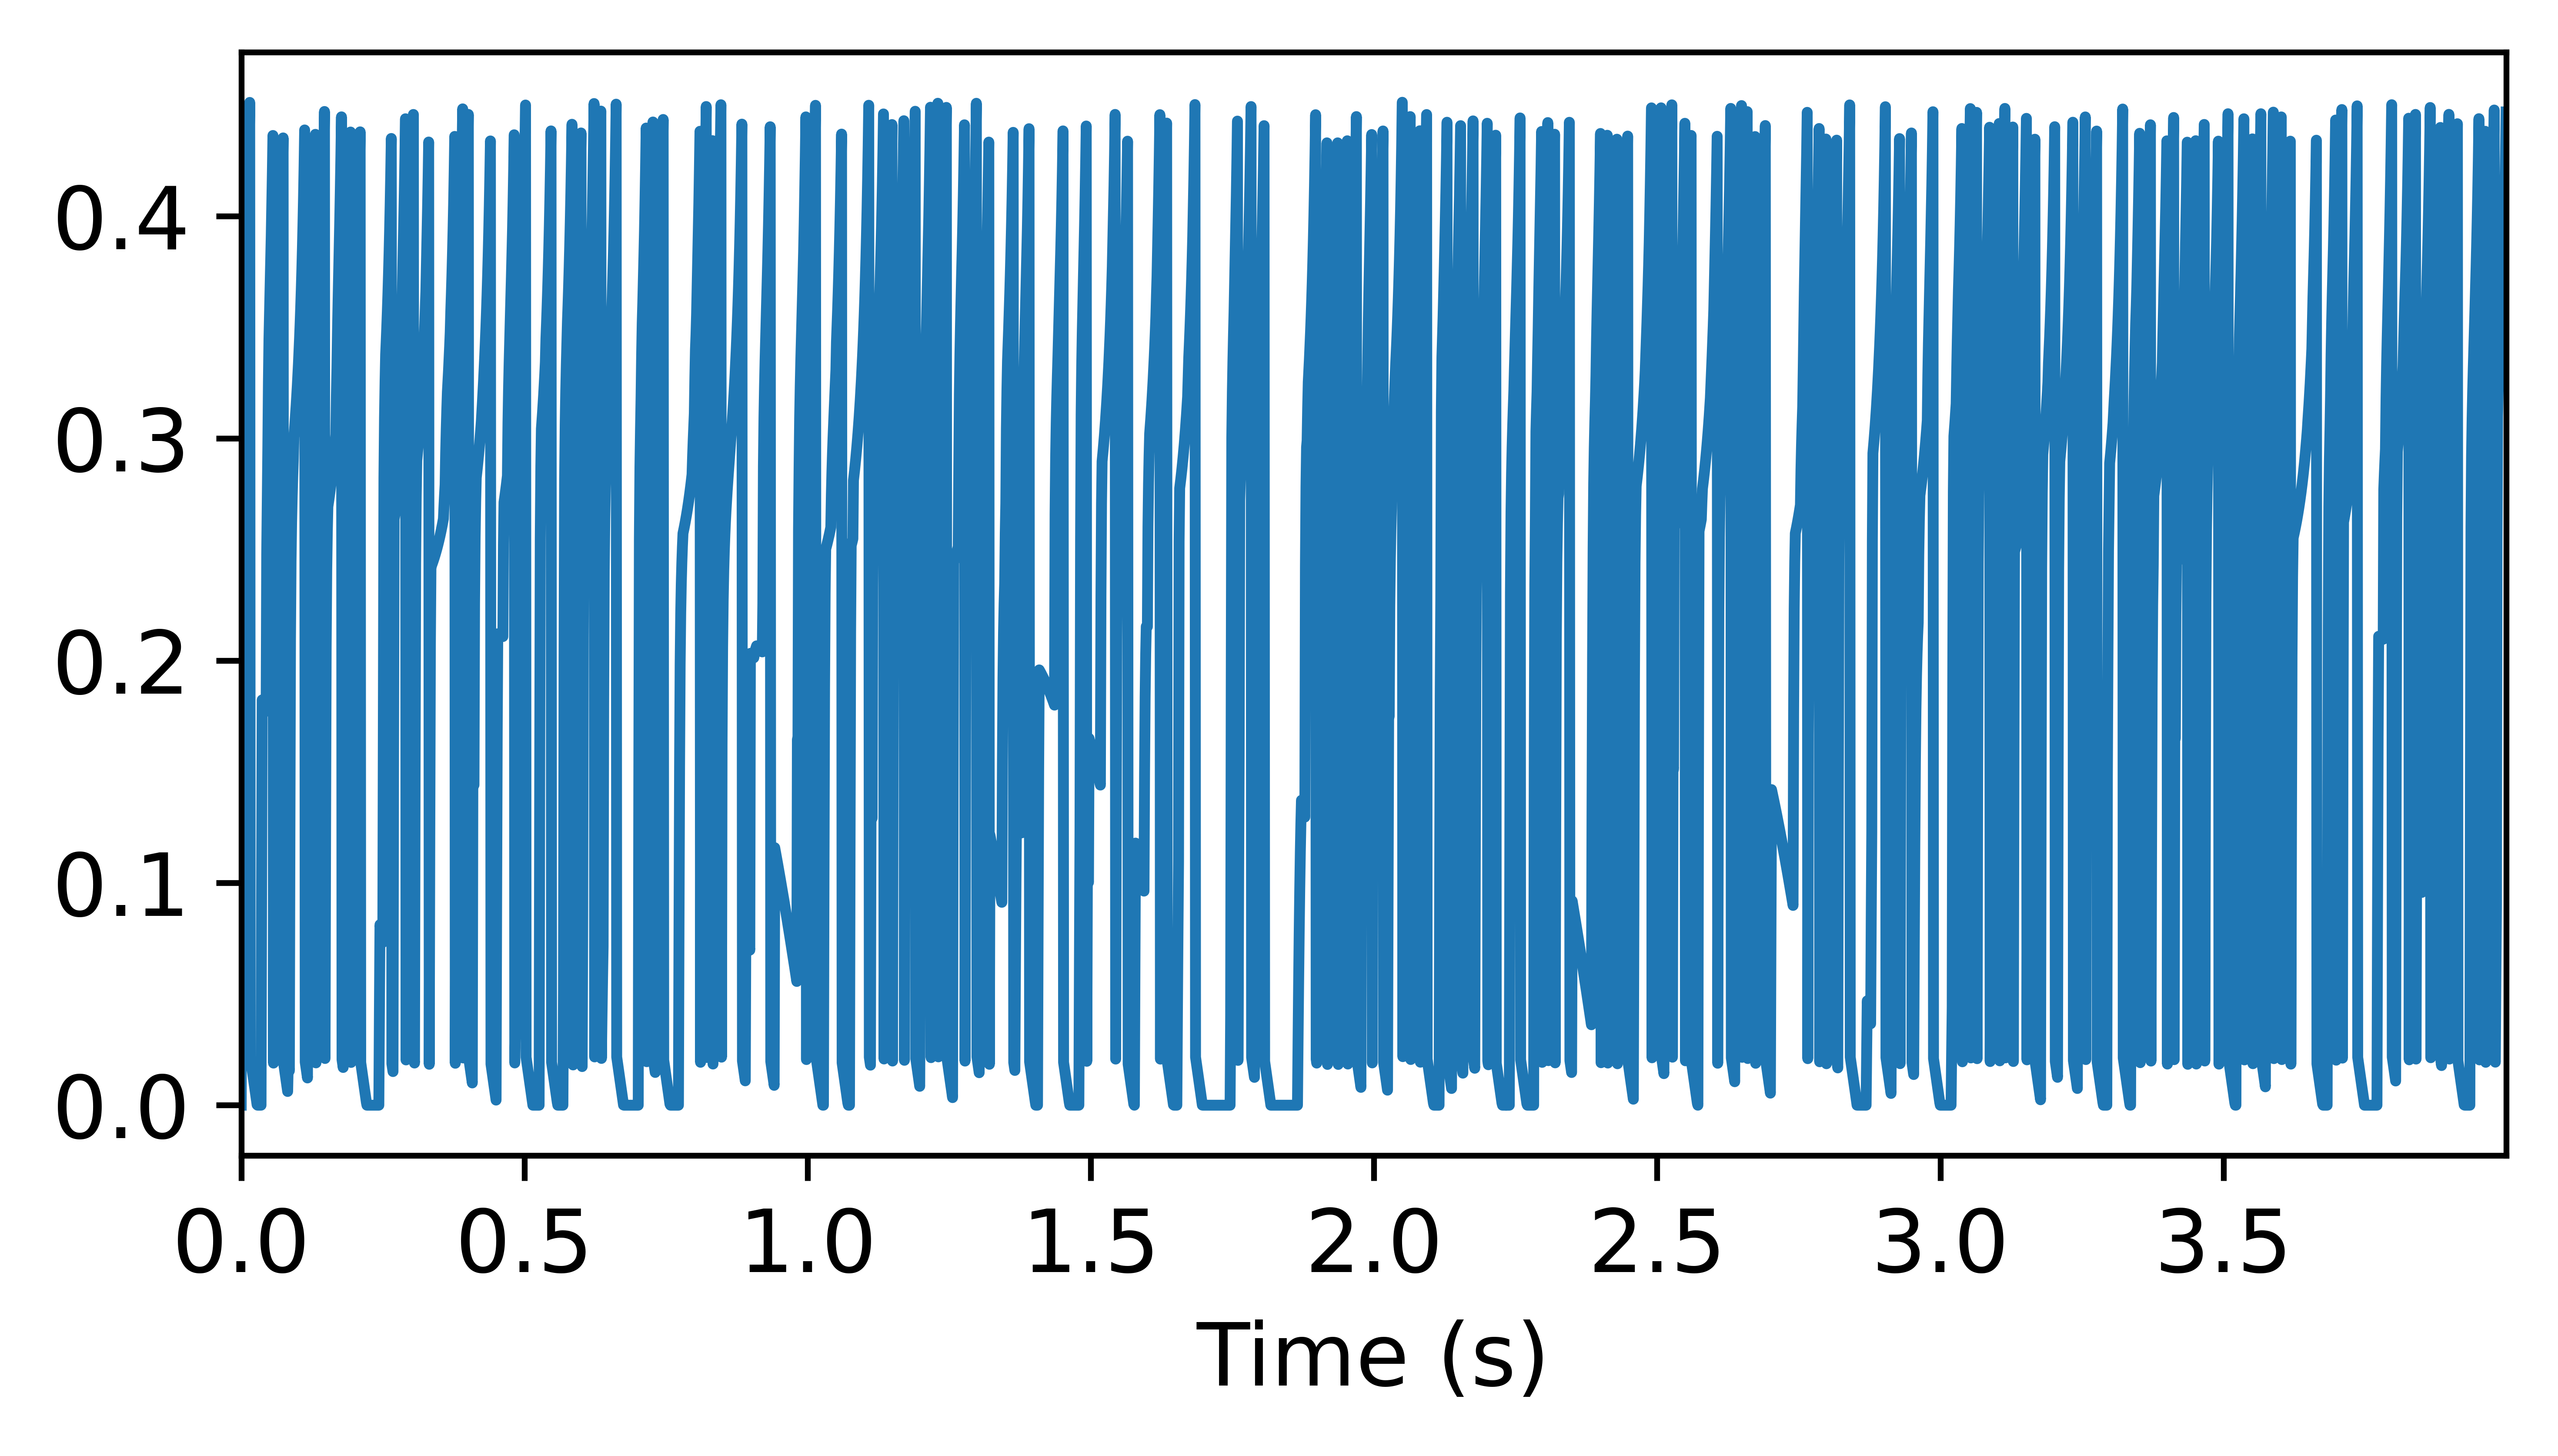

In [9]:
TSContinuous.from_clocked(rec['1_DynapSim']['vmem'][0,:,0], dt=dt).plot()

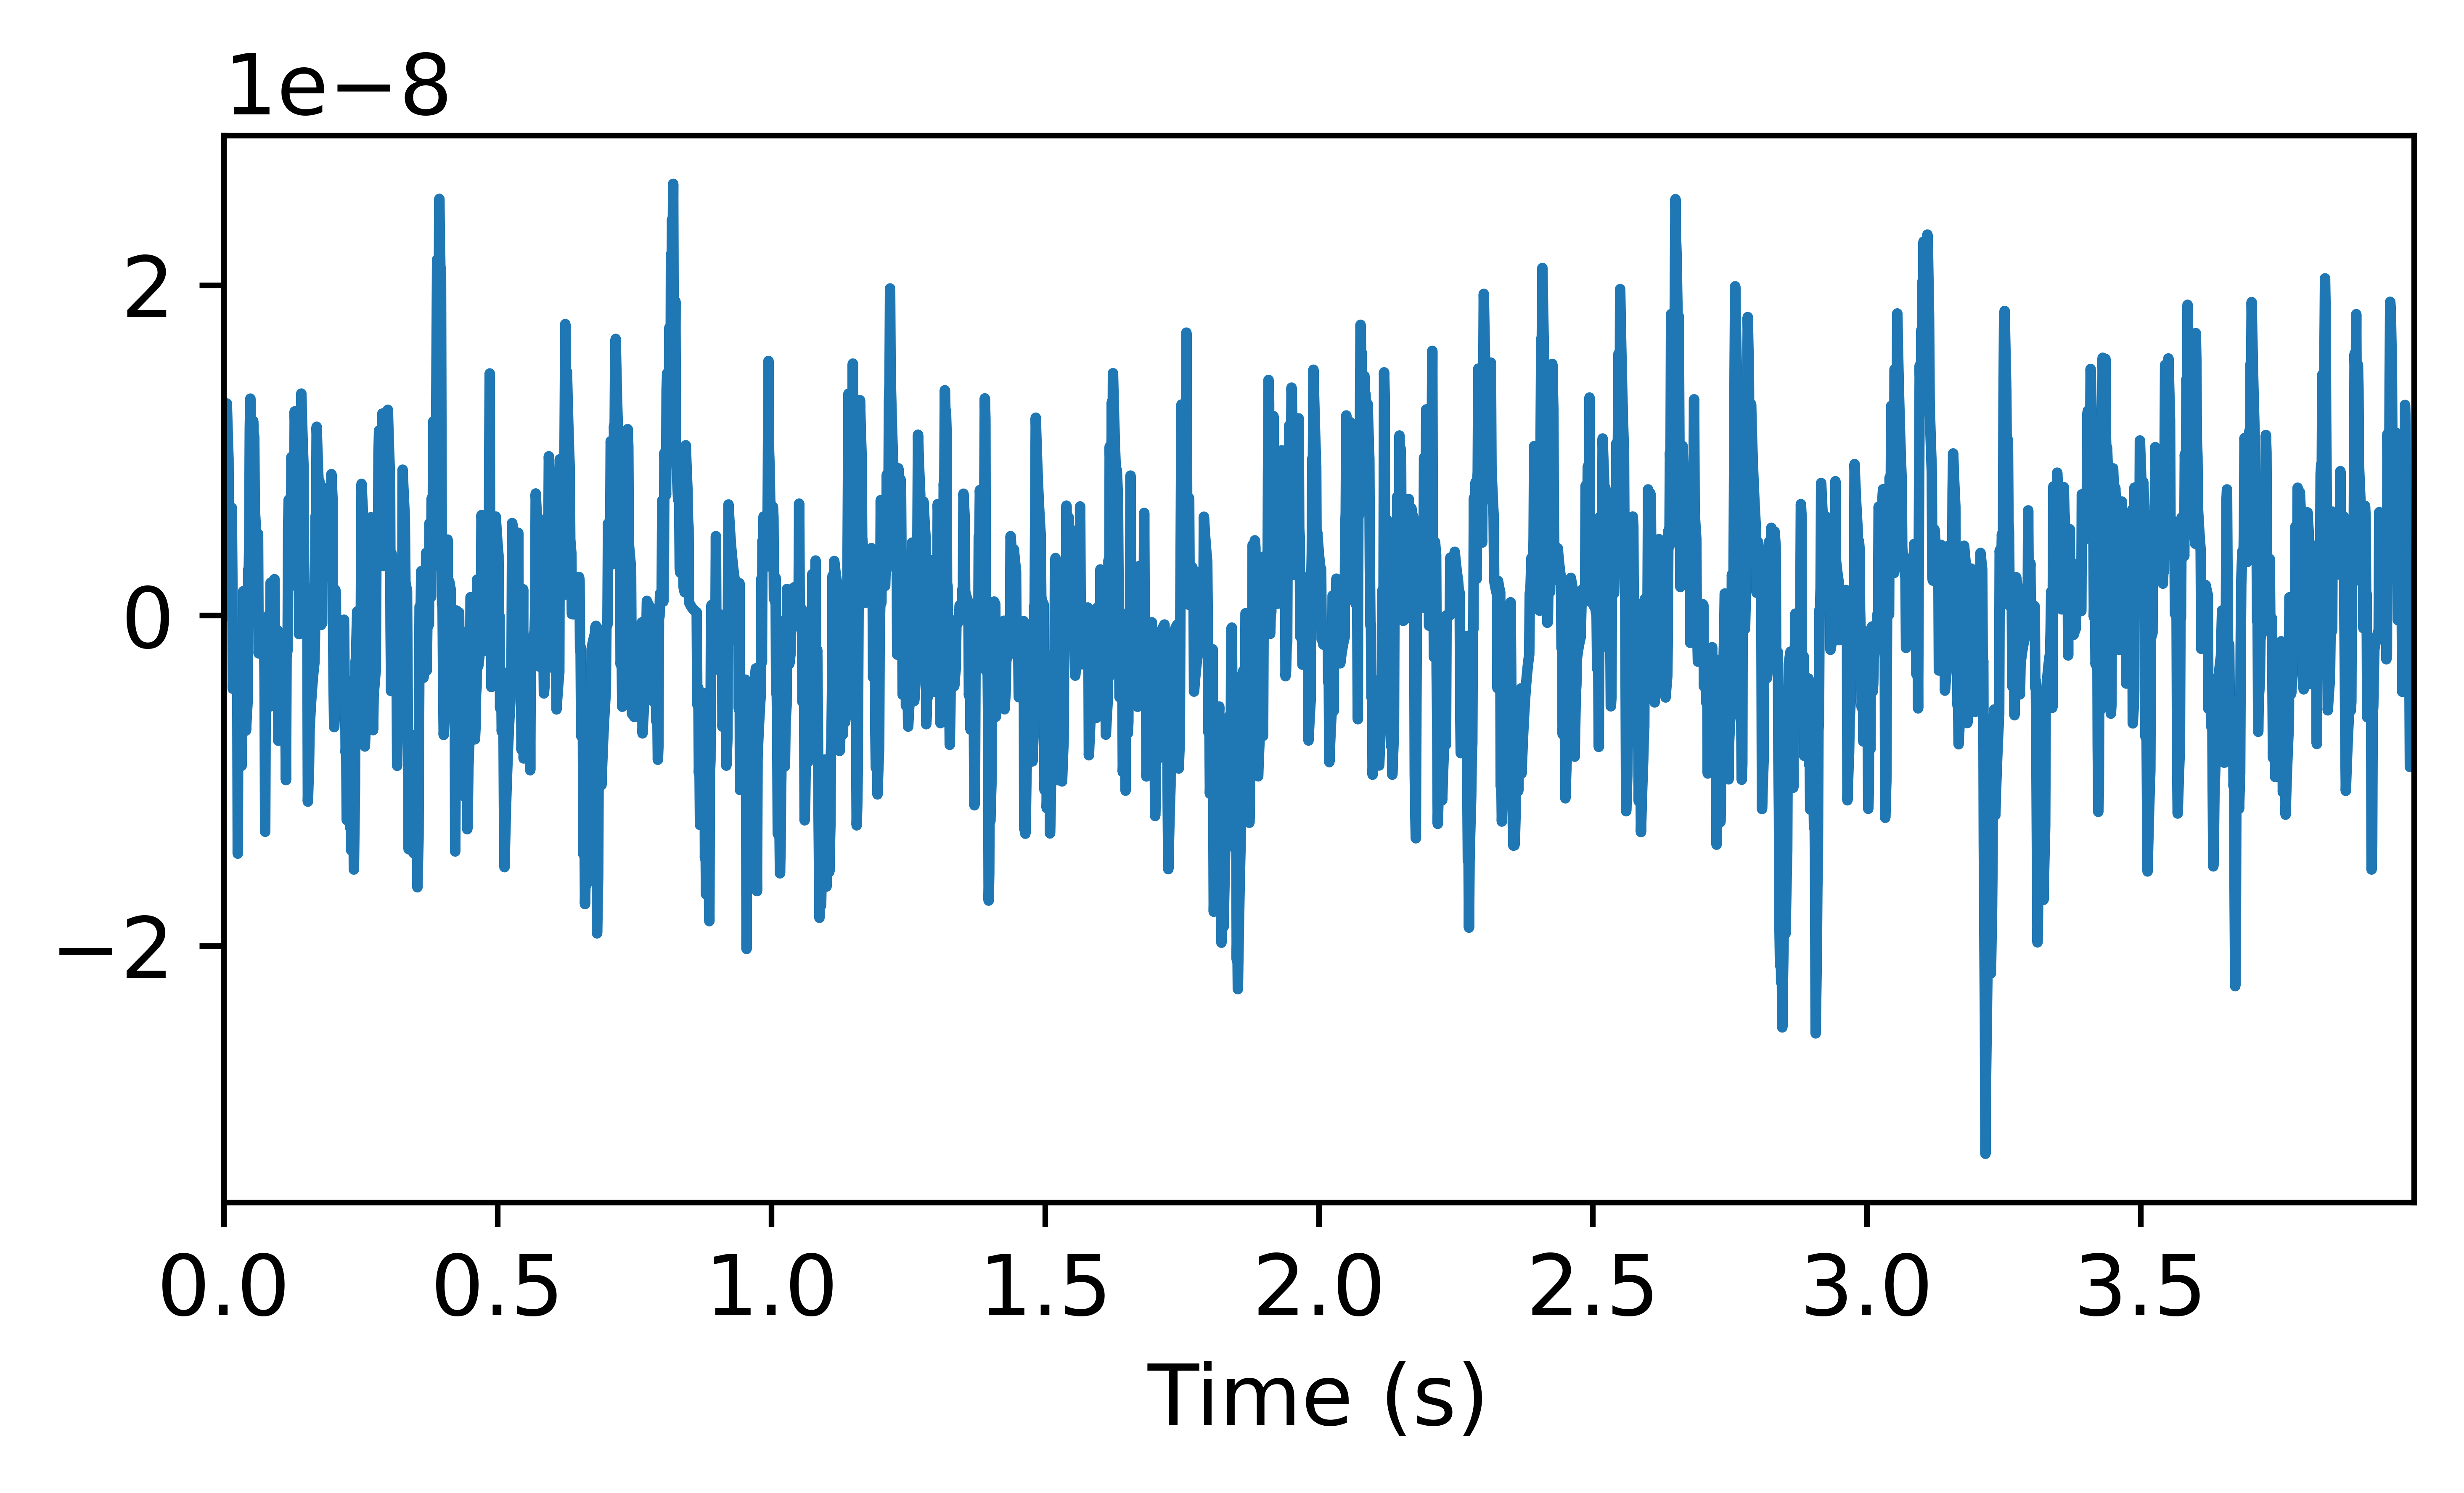

In [10]:
TSContinuous.from_clocked(rec['1_DynapSim']['isyn'][0,:,0], dt=dt).plot()

## Step 3 : Optimize

Load the weights from a trained network or train by yourself.

### Option : Load

In [11]:
with open("weight_opt.npy", "rb") as f:
    weight_opt = np.load(f)

net_2 = net.set_attributes({"0_LinearJax": {"weight": weight_opt}, "1_DynapSim": {}})


### Option : Train

In [12]:
# # - Initialise optimiser
# learning_rate = 1e-3
# init_fun, update_fun, get_params = adam(learning_rate)
# opt_state = init_fun(net.parameters())
# update_fun = jax.jit(update_fun)

# # - Loss function
# @jax.jit
# @jax.value_and_grad
# def loss_vgf(params, net, input, target):
#     net = net.set_attributes(params)
#     net = net.reset_state()
#     output, _, _ = net(input)
#     loss = jl.mse(output, target)
#     return loss

# loss_t = []

In [13]:
# # - Configure learning
# num_epochs = 20000

# # - Training loop
# t = tqdm(range(num_epochs), desc='Training', unit='Epoch', total=num_epochs)
    
# for epoch in t:
#     # - Get parameters
#     opt_parameters = get_params(opt_state)

#     # - Compute loss and gradient
#     l, g = loss_vgf(opt_parameters, net, input_spikes, target_spikes)
#     loss_t.append(l.item())
#     t.set_postfix({'loss': l.item()}, refresh = False)

#     # - Update optimiser
#     opt_state = update_fun(epoch, g, opt_state)

In [14]:
# plt.semilogy(loss_t)
# plt.yscale('log')
# plt.xlabel('Epoch')
# plt.ylabel('Loss Value')
# plt.tight_layout()

In [15]:
# net_2 = net.set_attributes(get_params(opt_state))
# with open('weight_opt.npy', 'wb') as f:
#     np.save(f, net_2[0].weight)

### Step 3.1 : Simulate

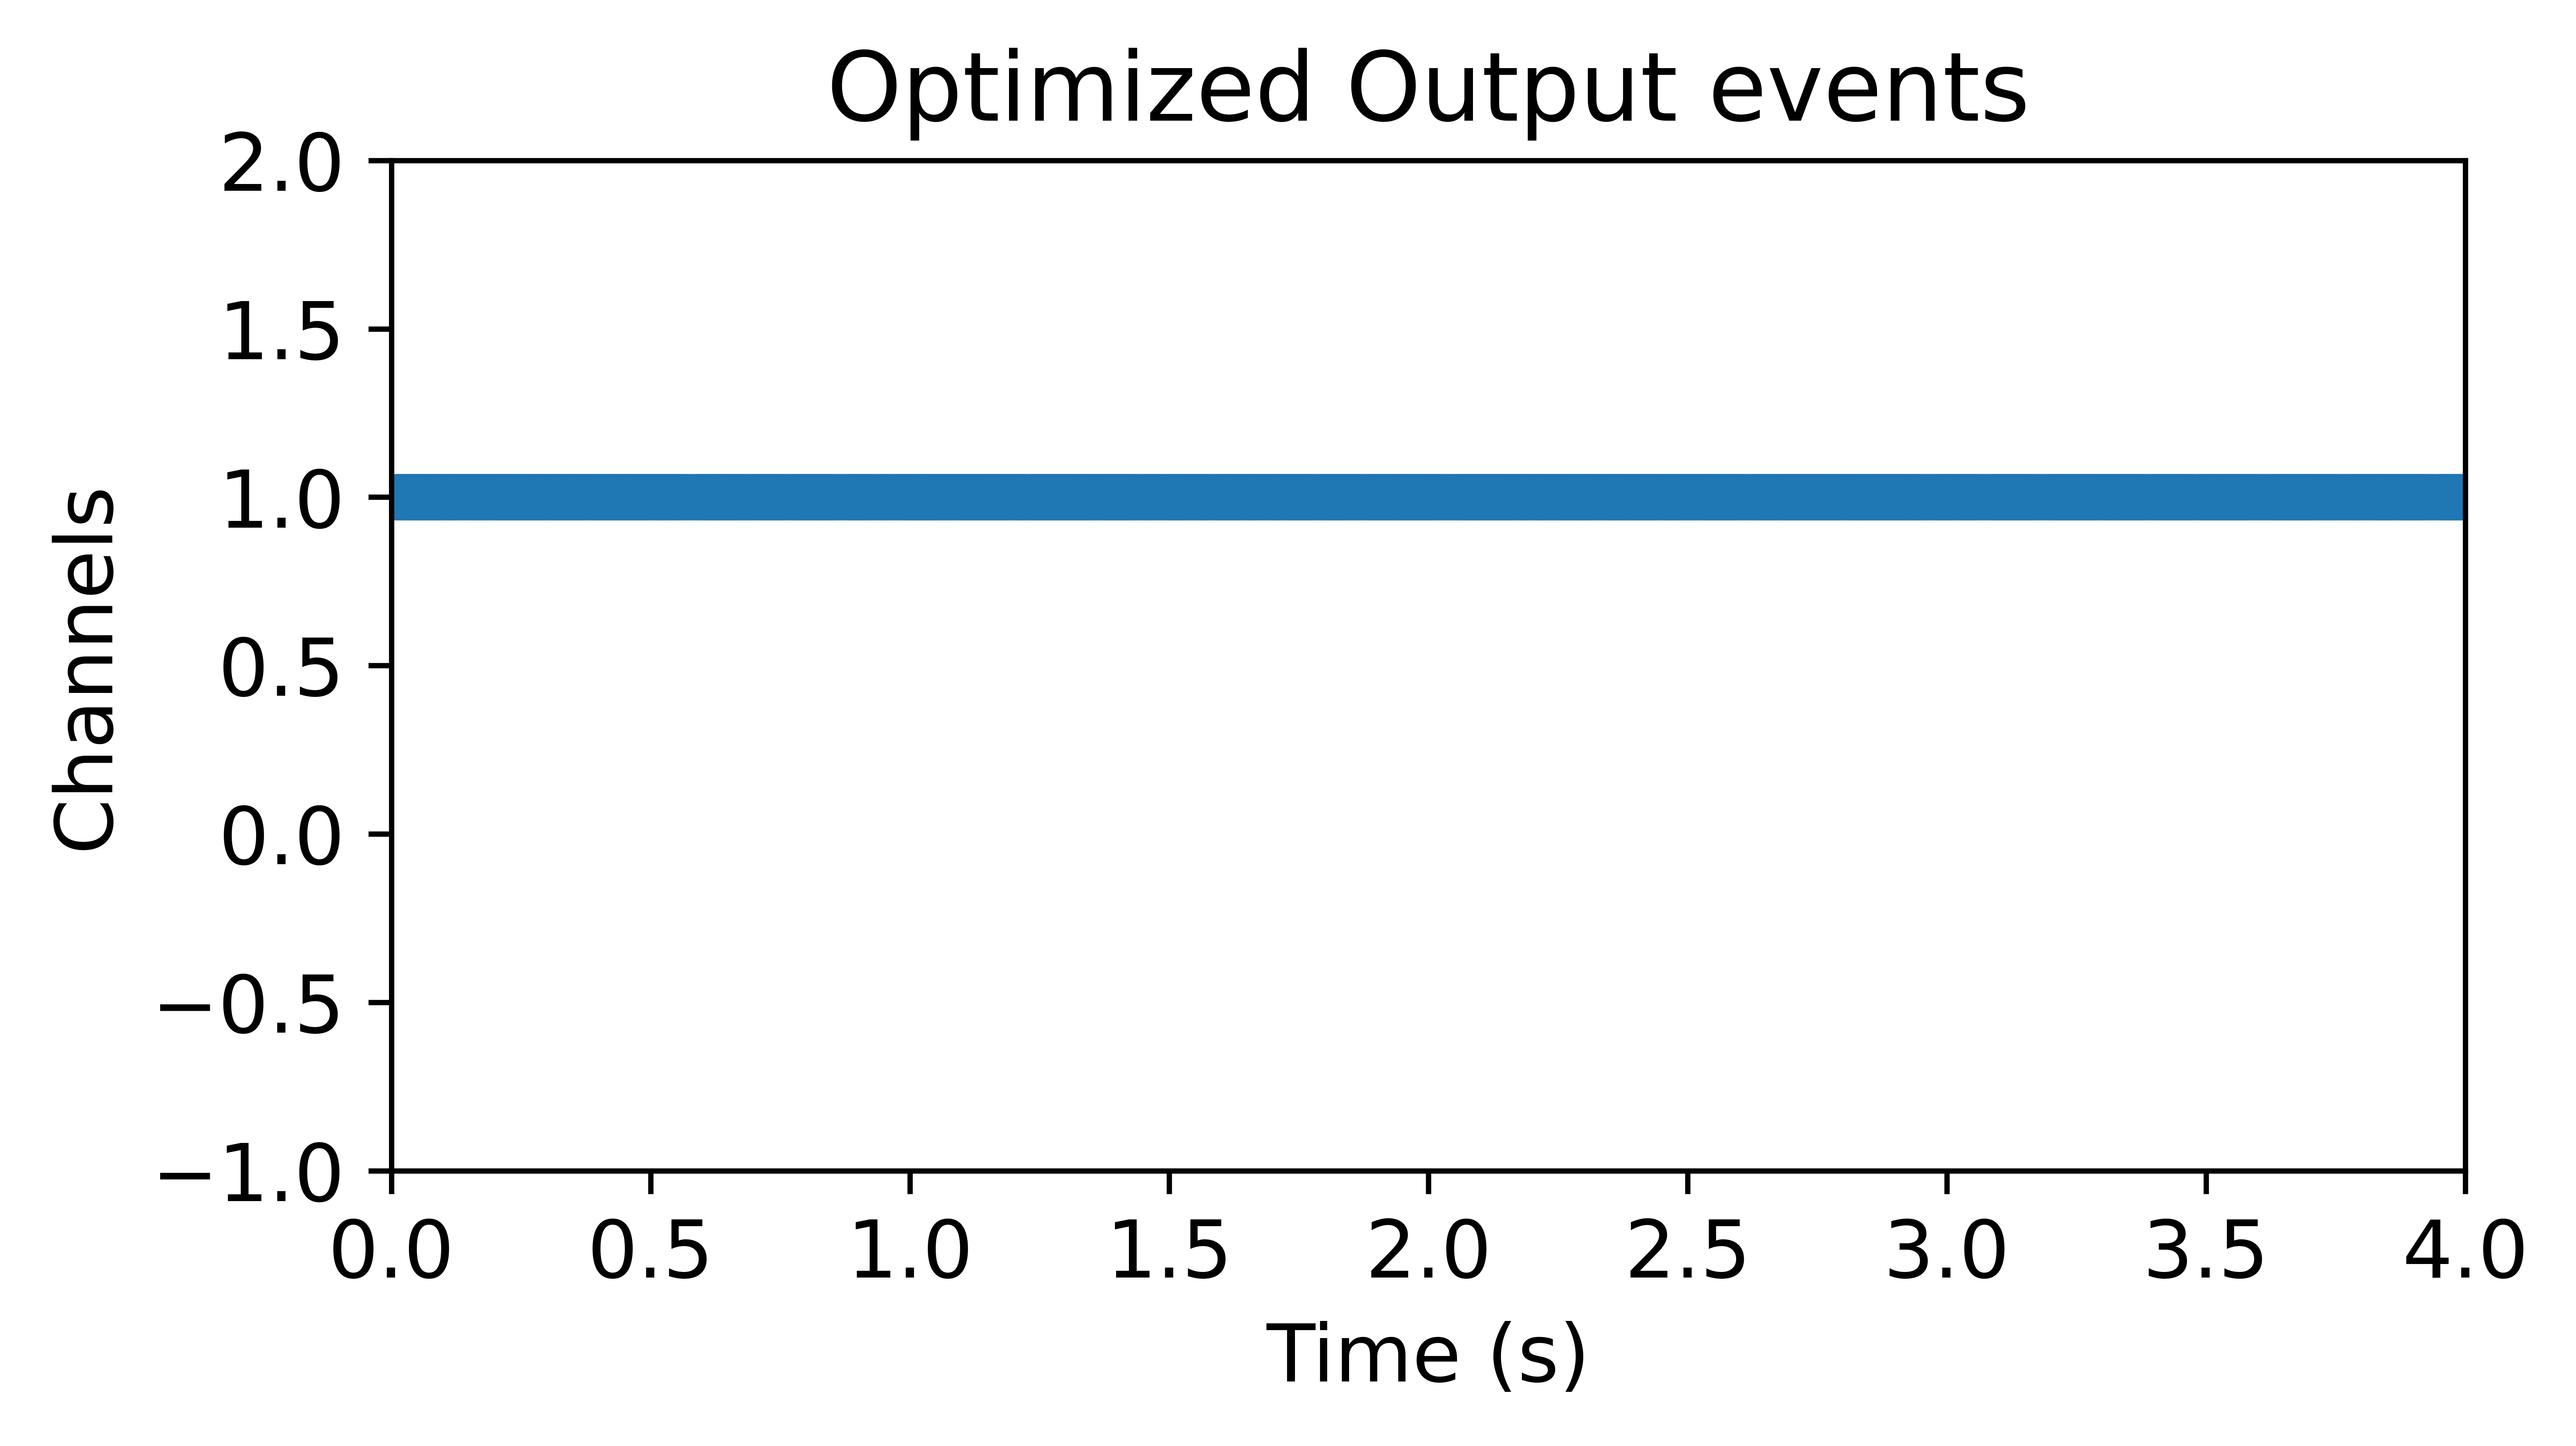

In [16]:
net_2.reset_state()
out_2, state_2, rec_2 = net_2(input_spikes)
TSEvent.from_raster(out_2[0], dt, name = 'Optimized Output events').plot();

## Step 4 : Extract the Computational Graph

In [17]:
net_2.as_graph()

GraphHolder "JaxSequential__11676348768" with 10 input nodes -> 2 output nodes

## Step 5 : Map the Network to a Hardware Specification

In [18]:
spec = mapper(net_2.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__11676348768" with 10 input nodes -> 2 output nodes,
 'weights_in': array([[-0.19521299,  1.4591457 ],
        [ 0.13886936,  1.2948742 ],
        [ 0.3618773 ,  1.2407901 ],
        [-0.69440496,  1.4122905 ],
        [-0.6269095 ,  1.4354316 ],
        [-0.9216108 ,  1.4985048 ],
        [ 0.09297284,  1.6289433 ],
        [-0.3145987 ,  1.6977041 ],
        [-0.7674705 ,  1.3941734 ],
        [-0.06240497,  1.5218244 ]], dtype=float32),
 'weights_rec': array([[-0.33298385, -0.19116156],
        [-1.2623904 ,  0.46005967]], dtype=float32),
 'Iscale': 1e-07,
 'Idc': [4.999999980020986e-13, 4.999999980020986e-13],
 'Itau_syn': [8.687943420238042e-11, 8.687943420238042e-11],
 'Itau_mem': [5.319148767279902e-12, 5.319148767279902e-12],
 'Iw_ahp': [0.0, 0.0],
 'Igain_ahp': [2.8368795160216287e-11, 2.8368795160216287e-11],
 'Iref': [1.049999975855087e-09, 1.049999975855087e-09],
 'Ispkthr': [1.0000000116860974e-07, 1.0000000116860974e-07],
 'Igai

In [19]:
spec.update(parameter_clustering(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11676348768" with 10 input nodes -> 2 output nodes,
 'weights_in': array([[-0.19521299,  1.4591457 ],
        [ 0.13886936,  1.2948742 ],
        [ 0.3618773 ,  1.2407901 ],
        [-0.69440496,  1.4122905 ],
        [-0.6269095 ,  1.4354316 ],
        [-0.9216108 ,  1.4985048 ],
        [ 0.09297284,  1.6289433 ],
        [-0.3145987 ,  1.6977041 ],
        [-0.7674705 ,  1.3941734 ],
        [-0.06240497,  1.5218244 ]], dtype=float32),
 'weights_rec': array([[-0.33298385, -0.19116156],
        [-1.2623904 ,  0.46005967]], dtype=float32),
 'Iscale': [1e-07],
 'Idc': [4.999999980020986e-13],
 'Itau_syn': [8.687943420238042e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Iw_ahp': [0.0],
 'Igain_ahp': [2.8368795160216287e-11],
 'Iref': [1.049999975855087e-09],
 'Ispkthr': [1.0000000116860974e-07],
 'Igain_syn': [8.687943697793798e-09],
 'If_nmda': [4.999999980020986e-13],
 'Igain_mem': [2.1276595069119608e-11],
 'Ipulse_ahp': [0.349999994039535

## Step 6 : Quantize Weights

In [20]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11676348768" with 10 input nodes -> 2 output nodes,
 'weights_in': [array([[ 0, 15],
         [ 0, 11],
         [ 2, 14],
         [ 3, 15],
         [ 3, 13],
         [ 9, 15],
         [ 0, 15],
         [ 2, 15],
         [ 8, 15],
         [ 0, 15]], dtype=int32)],
 'weights_rec': [array([[ 8,  0],
         [13,  1]], dtype=int32)],
 'Iscale': [1e-07],
 'Idc': [4.999999980020986e-13],
 'Itau_syn': [8.687943420238042e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Iw_ahp': [0.0],
 'Igain_ahp': [2.8368795160216287e-11],
 'Iref': [1.049999975855087e-09],
 'Ispkthr': [1.0000000116860974e-07],
 'Igain_syn': [8.687943697793798e-09],
 'If_nmda': [4.999999980020986e-13],
 'Igain_mem': [2.1276595069119608e-11],
 'Ipulse_ahp': [0.3499999940395355],
 'Ipulse': [3.4999999343199306e-08],
 'Itau_ahp': [2.8368795160216287e-11],
 'n_cluster': 1,
 'core_map': array([0, 0]),
 'n_neuron': 2,
 'sign_in': [array([[-1.,  1.],
         [ 1.,  1.],
         [ 1

## Step 7 : Quantize Parameters

In [21]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11676348768" with 10 input nodes -> 2 output nodes,
 'weights_in': [array([[ 0, 15],
         [ 0, 11],
         [ 2, 14],
         [ 3, 15],
         [ 3, 13],
         [ 9, 15],
         [ 0, 15],
         [ 2, 15],
         [ 8, 15],
         [ 0, 15]], dtype=int32)],
 'weights_rec': [array([[ 8,  0],
         [13,  1]], dtype=int32)],
 'Iscale': [1e-07],
 'Idc': [4.999999980020986e-13],
 'Itau_syn': [8.687943420238042e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Iw_ahp': [0.0],
 'Igain_ahp': [2.8368795160216287e-11],
 'Iref': [1.049999975855087e-09],
 'Ispkthr': [1.0000000116860974e-07],
 'Igain_syn': [8.687943697793798e-09],
 'If_nmda': [4.999999980020986e-13],
 'Igain_mem': [2.1276595069119608e-11],
 'Ipulse_ahp': [0.3499999940395355],
 'Ipulse': [3.4999999343199306e-08],
 'Itau_ahp': [2.8368795160216287e-11],
 'n_cluster': 1,
 'core_map': array([0, 0]),
 'n_neuron': 2,
 'sign_in': [array([[-1.,  1.],
         [ 1.,  1.],
         [ 1

In [22]:
input_spikes[0].shape

(4000, 10)

Rate = 372.0


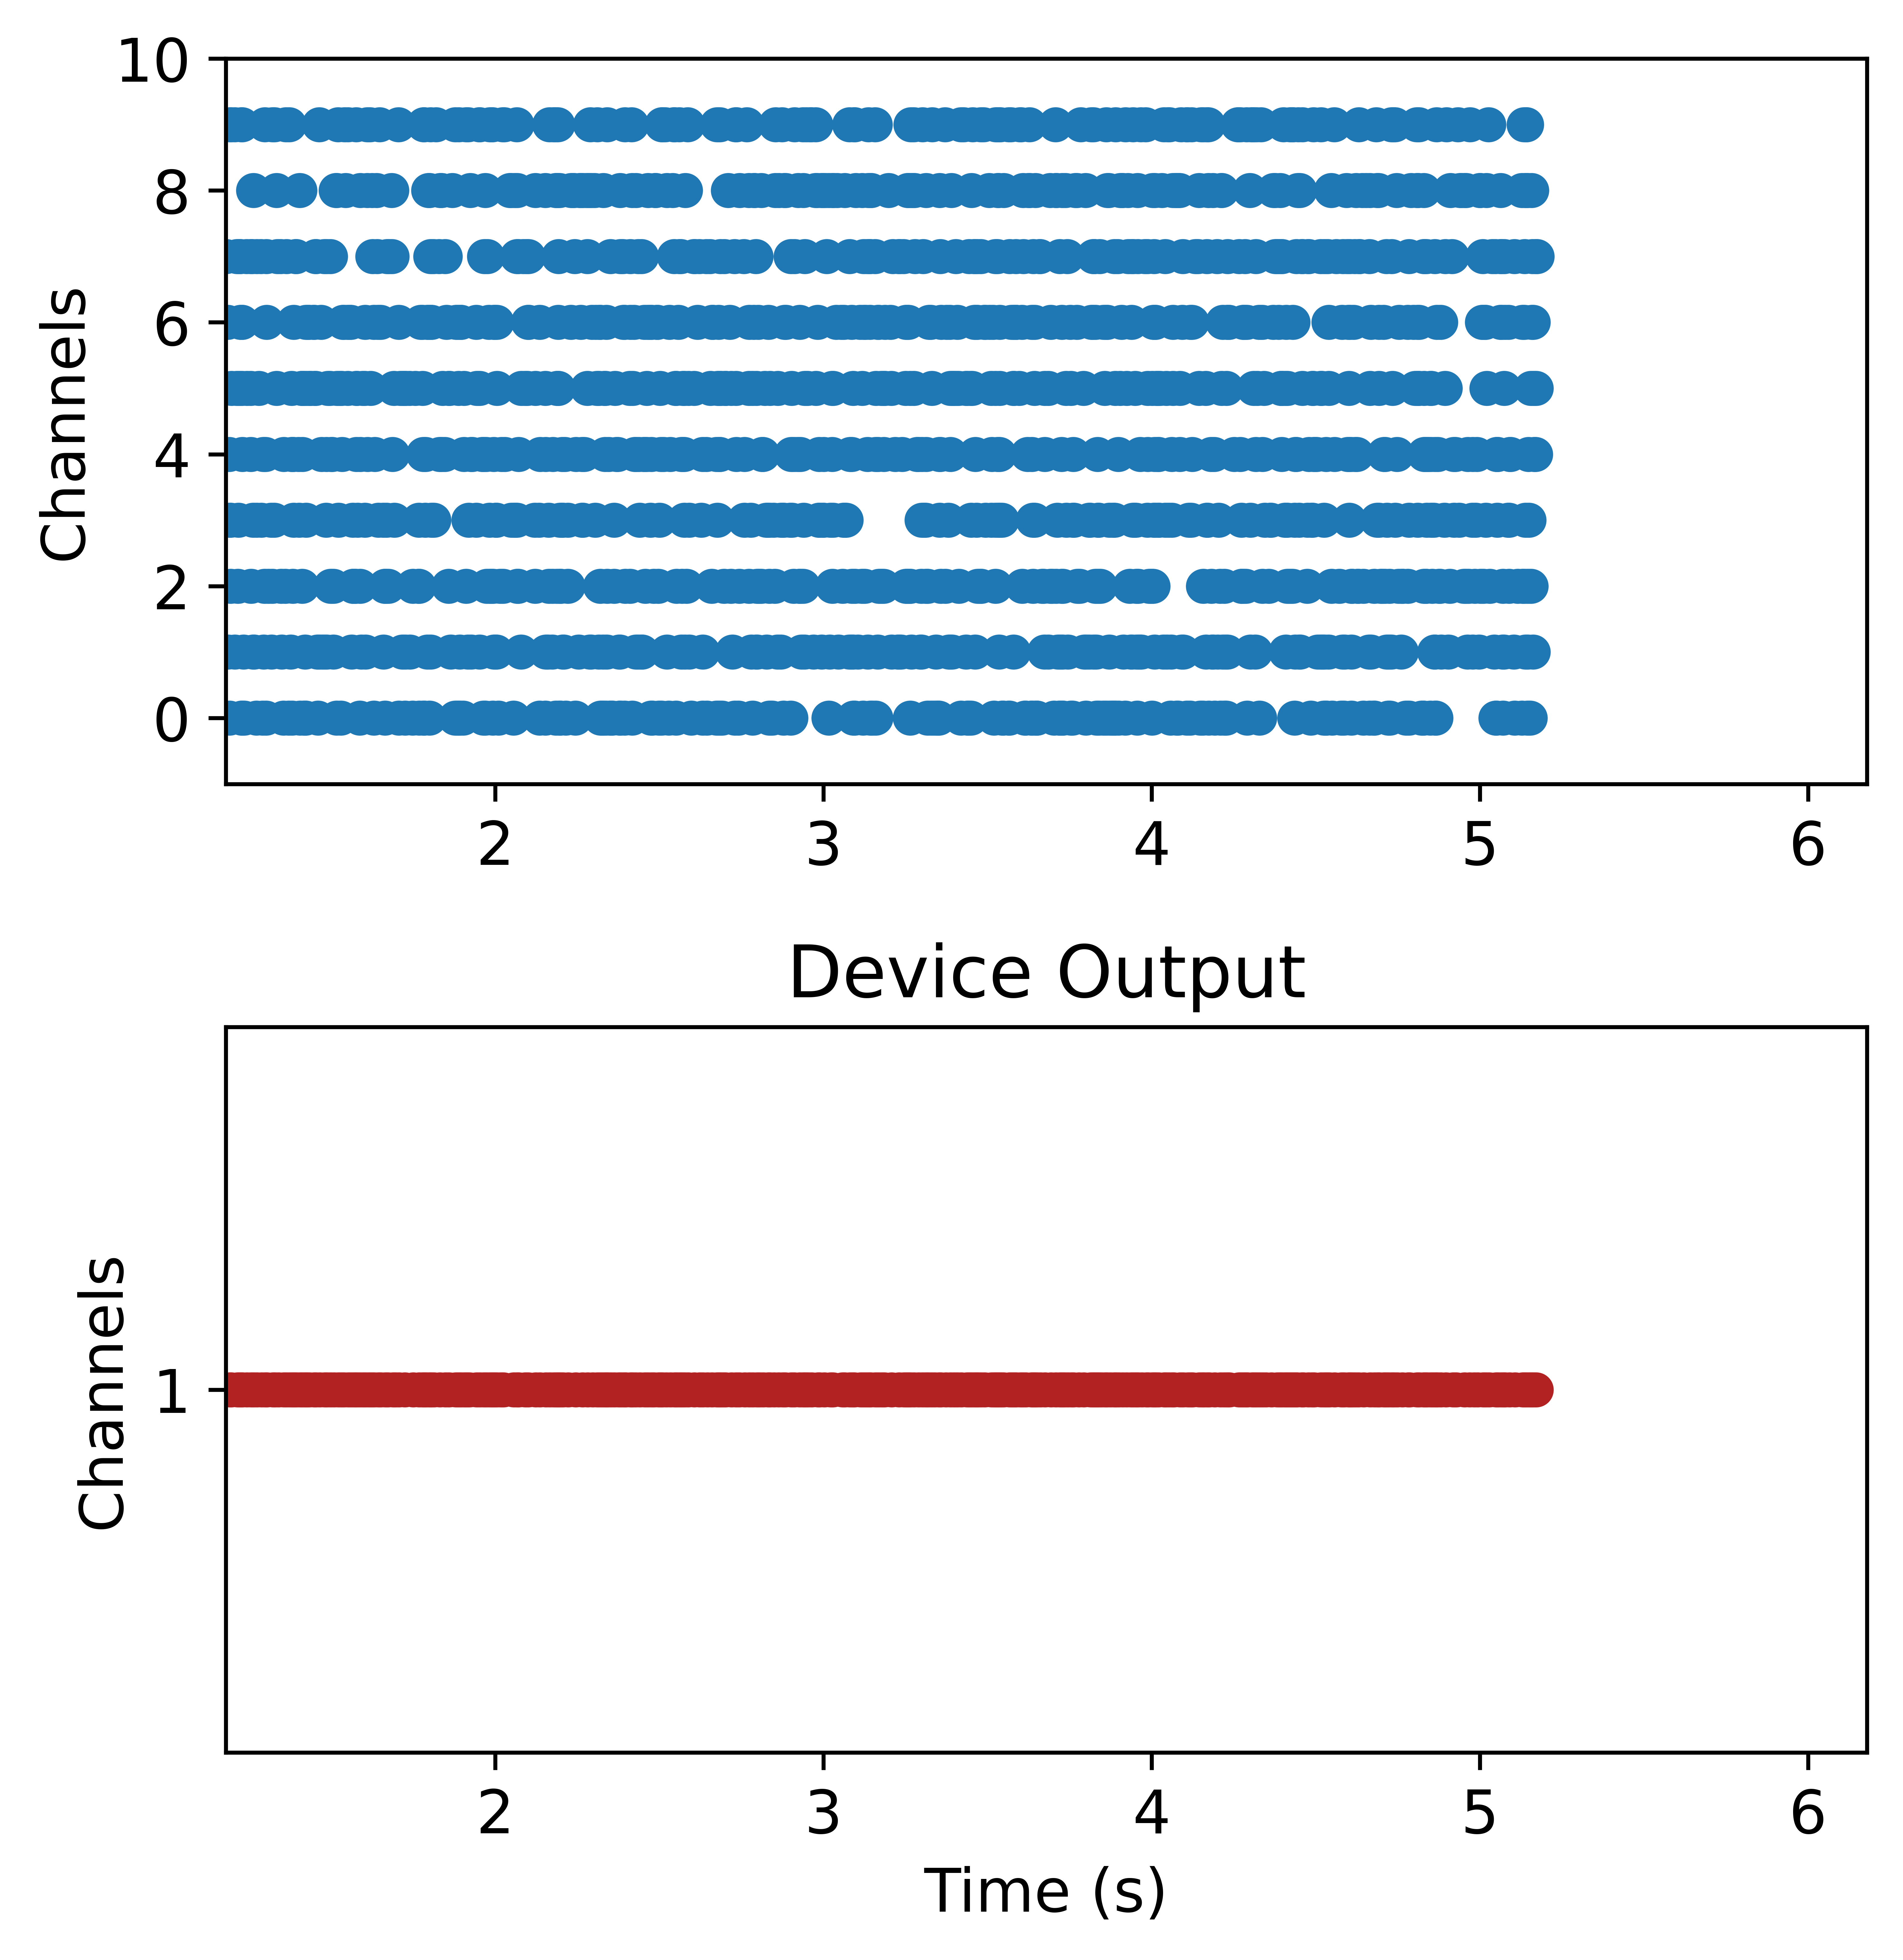

In [23]:
plt.rcParams["figure.figsize"] = [5.6, 5.6]
test_network(spec, input_spikes[0])